# Setup

In [19]:

import pandas as pd
import numpy as np
import seaborn as sns
import math
import statistics
import os
import re
from datetime import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import config as config
from rea_python.main.database import DBCopyMode, RedshiftHook
from rea_python.constants import OutputFormat

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

sql_path = os.path.join(os.path.dirname(os.path.realpath('EnblocImbClass.ipynb')), 'sql')

# initialize redshift hook
src_hook = RedshiftHook(iam_role_arn=config.IAM_ROLE_ARN,
                        via_s3_bucket=config.REDSHIFT_HOOK_BRIDGE_BUCKET,
                        via_s3_folder=config.REDSHIFT_HOOK_BRIDGE_FOLDER)

# set up connection
src_hook.set_conn_from_uri(config.DATA_WAREHOUSE_URI)

# load queries from sql
src_hook.load_queries_from_folders([sql_path])
df = src_hook.execute_loaded_query(query_name='data_query', output_format=OutputFormat.pandas)


enbloc_df = df[df['enbloc'] == 1]
nonenbloc_df = df[df['enbloc'] == 0]
condo_df = df[df['property_type_group'] == 'condo']
landed_df = df[df['property_type_group'] == 'landed']
condo_df['lot_size_num_units_ratio'] = condo_df.lot_size_sqft/condo_df.num_of_units
landed_df['lot_size_num_units_ratio'] = landed_df.lot_size_sqft/landed_df.num_of_units

condo_df.dropna(subset=['lease_type','approx_project_gfa','avg_area_sqft','region','zone'], inplace=True)
landed_df.dropna(subset=['lease_type','approx_project_gfa','avg_area_sqft','region','zone'], inplace=True)

def preprocess(df, cols, dummies):
    #dropna
    df.dropna(subset=['lease_type','approx_project_gfa','avg_area_sqft','region','zone'], inplace=True)
    df = df.loc[:,['project_name','km_to_sg_cbd','lot_size_sqft','project_age','num_of_units','approx_project_gfa','lot_size_num_units_ratio','avg_area_sqft','region','zone','lease_type','enbloc']]
    #impute mean
    for col in cols:
        df[col] = df[col].fillna(value = df[col].mean()) 
    #get dummies
    df = pd.get_dummies(df, columns=dummies)
    names = df.project_name
    ndf = df.loc[:,['project_name','project_age','num_of_units','lot_size_num_units_ratio','approx_project_gfa']]
    df = df.drop('project_name',axis=1)
    enbloc = df.enbloc
    x = df.loc[:, df.columns != 'enbloc']
    return df, names, enbloc, x, ndf

cols = ['project_age','km_to_sg_cbd','lot_size_sqft','num_of_units','lot_size_num_units_ratio']
dummies = ['region','zone','lease_type']

cdf, cnames, cenbloc, cx, cndf = preprocess(condo_df,cols,dummies)
ldf, lnames, lenbloc, lx, lndf = preprocess(landed_df,cols,dummies)
def make_results(model_names, model_list, x, names, enbloc, ndf):
    
    pred = lambda model:pd.DataFrame(model.predict_proba(x)).iloc[:,1]
    models = list(map(pred,model_list))
    
    data = {"project_name": pd.DataFrame(names.values),
            "enbloc": pd.DataFrame(enbloc.values),
            f"{model_names[0]}": models[0],
            f"{model_names[1]}": models[1],
            f"{model_names[2]}": models[2],
            f"{model_names[3]}": models[3],
            f"{model_names[4]}": models[4],
            f"{model_names[5]}": models[5],
            f"{model_names[6]}": models[6],
            f"{model_names[7]}": models[7],
           }

    results = pd.concat(data,axis=1)
    model_results = results.iloc[:,2:]
    results['average'] = model_results.mean(numeric_only=True, axis=1)
    results.columns = results.columns.droplevel(1)
    results = results.sort_values('average', ascending = False)
    results['proportion'] = results.enbloc.sum()/results.shape[0]
    return results.merge(ndf, on='project_name', how='left')


from pycaret.classification import *

lcaret = setup(data=ldf, target='enbloc', 
                    train_size=0.7, preprocess=False,
                    fix_imbalance=True,
                    data_split_stratify=True,
                    transformation=True,
                    normalize=True,
                    normalize_method='robust',
                    session_id=2)

l10 = compare_models(n_select=10, sort='AUC')

# Results

In [20]:

pd.options.display.float_format = '{:,.3f}'.format
lr = pull()
lmodel_names = lr.index.values
landed_results = make_results(lmodel_names ,l10, lx, lnames, lenbloc, lndf)
landed_results

project_name  enbloc    rf  lightgbm   ada    et    nb   gbc    dt  \
0      HILLSIDE GARDENS       1 0.900     0.999 0.724 1.000 1.000 0.994 1.000   
1           NEW GARDENS       1 0.880     1.000 0.661 1.000 0.999 0.993 1.000   
2          MARTIA COURT       1 0.820     0.999 0.712 1.000 0.999 0.991 1.000   
3      SOUTH LAKE VILLA       1 0.780     0.999 0.689 1.000 0.999 0.994 1.000   
4          FORT TERRACE       1 0.800     0.999 0.644 1.000 1.000 0.993 1.000   
..                  ...     ...   ...       ...   ...   ...   ...   ...   ...   
475        KIM LIN PARK       0 0.000     0.000 0.033 0.000 0.000 0.000 0.000   
476  GOLDEN RISE ESTATE       0 0.000     0.000 0.028 0.000 0.000 0.000 0.000   
477          KINGSVILLE       0 0.000     0.000 0.017 0.000 0.000 0.000 0.000   
478        SANDY ISLAND       0 0.000     0.000 0.016 0.000 0.000 0.000 0.000   
479        CORAL ISLAND       0 0.000     0.000 0.016 0.000 0.000 0.000 0.000   

       lr  average  proportion  project_age  num_of_units  \
0   0.160    0.847       0.037       24.000         9.000   
1   0.152    0.836       0.037       24.524        12.000   
2   0.051    0.822       0.037       24.524        12.000   
3   0.084    0.818       0.037       21.000         7.000   
4   0.093    0.816       0.037       24.524        16.000   
..    ...      ...         ...          ...           ...   
475 0.000    0.004       0.037        0.000       161.000   
476 0.000    0.004       0.037       16.000        83.000   
477 0.000    0.002       0.037       22.000       106.000   
478 0.001    0.002       0.037       10.000        18.000   
479 0.000    0.002       0.037       14.000        21.000   

     lot_size_num_units_ratio  approx_project_gfa  
0                       9.817          19,859.000  
1                       9.817          24,477.000  
2                       9.817          40,365.000  
3                       9.817          21,301.000  
4                       9.817          36,922.000  
..                        ...                 ...  
475                     0.292         610,776.000  
476                     0.475         130,393.000  
477                     0.264         288,001.000  
478                     4.191         127,531.000  
479                     3.888         161,129.000  

[480 rows x 16 columns]

# Histograms

<AxesSubplot:xlabel='km_to_sg_cbd', ylabel='Probability'>

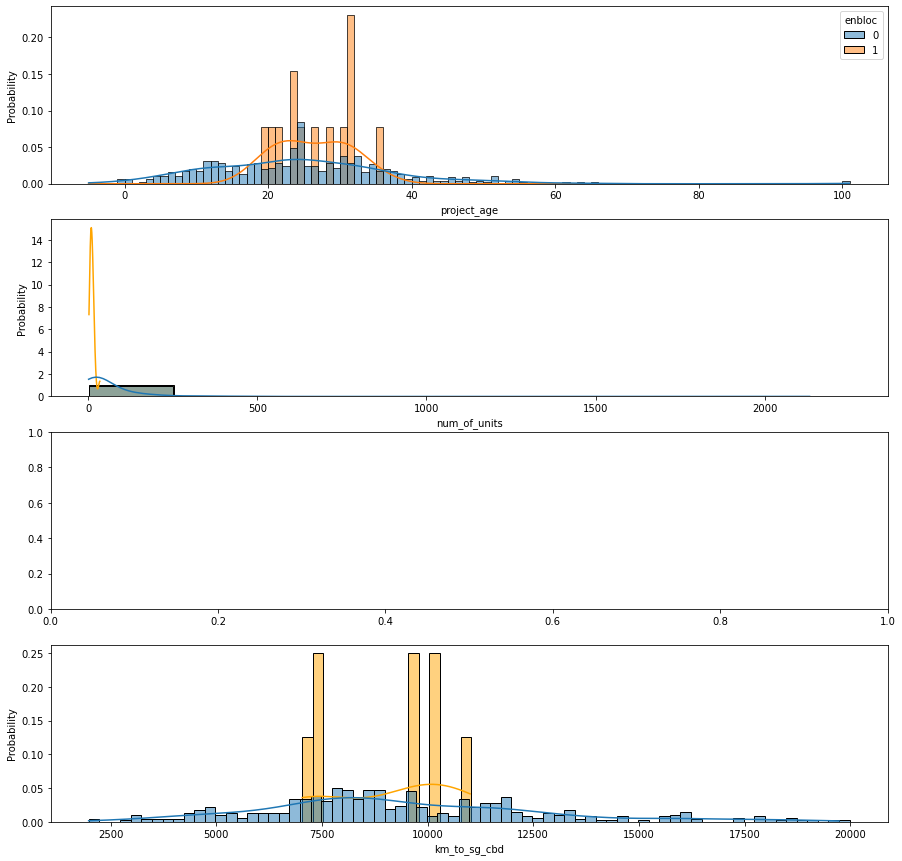

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(15,15))
sns.histplot(landed_df.dropna(subset=['project_age']), x='project_age', hue='enbloc',common_norm=0,stat='probability', kde='1',binwidth=1,ax=ax1)
sns.histplot(landed_df.dropna(subset=['num_of_units'])[landed_df.enbloc==True], x='num_of_units', stat='probability', kde='1',binwidth=250,ax=ax2,color='orange')
sns.histplot(landed_df.dropna(subset=['num_of_units'])[landed_df.enbloc==False], x='num_of_units', stat='probability', kde='1',binwidth=250,ax=ax2)
sns.histplot(landed_df.dropna(subset=['km_to_sg_cbd'])[landed_df.enbloc==True], x='km_to_sg_cbd', stat='probability', kde='1',binwidth=250,ax=ax4,color='orange')
sns.histplot(landed_df.dropna(subset=['km_to_sg_cbd'])[landed_df.enbloc==False], x='km_to_sg_cbd', stat='probability', kde='1',binwidth=250,ax=ax4)


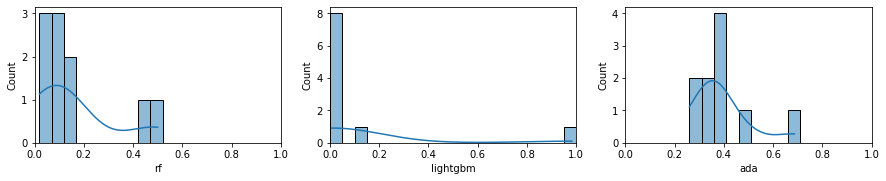

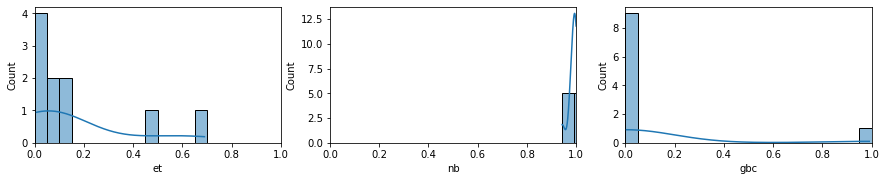

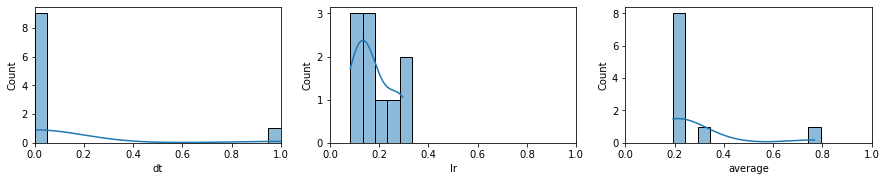

In [5]:


def histies(df, features):
    for i in range(len(features)):
        if i % 3 == 0:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 2.5))
            ax1.set_xlim(0,1)
            ax2.set_xlim(0,1)
            ax3.set_xlim(0,1)
            sns.histplot(df, x=features[i],stat='count', kde='1',binwidth=0.05,ax=ax1)

        elif i % 3 == 1:
            sns.histplot(df, x=features[i],stat='count', kde='1',binwidth=0.05,ax=ax2)
        else:
            sns.histplot(df, x=features[i],stat='count', kde='1',binwidth=0.05,ax=ax3)    
    plt.show()
    
    
features = landed_results.columns[2:11]    
histies(landed_results.head(10), features)

# Feature importances

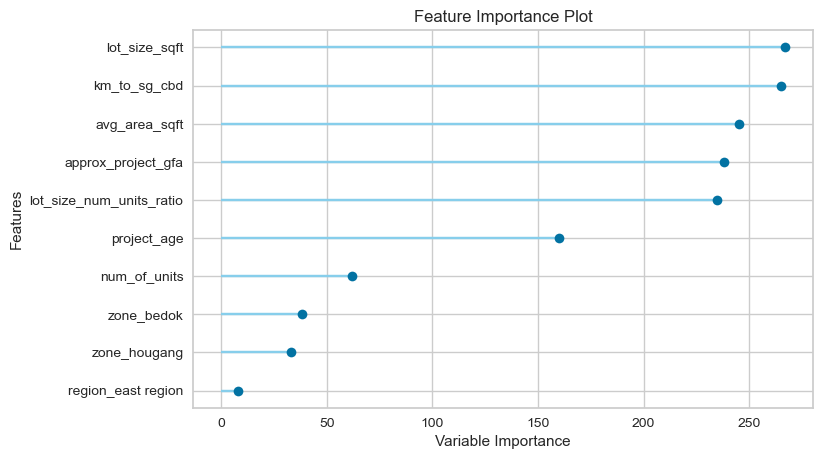

In [9]:
plot_model(l10[1],'feature')

# KL-JS(P||Q) and SHAP

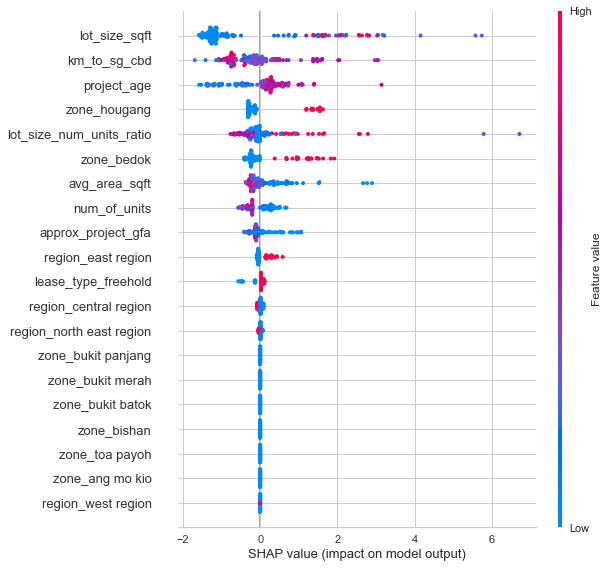

In [10]:
interpret_model(l10[1])

## Clustering

In [26]:
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

def cluster(x, ndf, clusters, results):
    '''
    args:
    x:        pd.DataFrame. The df of x values.
    ndf:      pd.DataFrame. The df of property names. One of 'cndf', 'lndf'.
    clusters: int. Num of clusters. 
    results:  pd.DataFrame. The df of the original results.
    
    '''
    x = x.loc[:,['km_to_sg_cbd','lot_size_sqft','project_age','num_of_units','approx_project_gfa','lot_size_num_units_ratio','avg_area_sqft', 'lease_type_freehold','lease_type_leasehold']]
    x = PowerTransformer().fit_transform(x)
    x = pd.DataFrame(x, index=ndf.index)
    
    km = pd.Series(KMeans(n_clusters=clusters, random_state=0).fit_predict(x), index=ndf.project_name)
    aggl = pd.Series(AgglomerativeClustering(n_clusters=clusters).fit_predict(x), index=ndf.project_name)
    gmm = pd.Series(GaussianMixture(n_components=clusters, random_state=0).fit_predict(x), index=ndf.project_name)
    
    clusters = pd.concat({'km':km, 'aggl':aggl, 'gmm':gmm}, axis=1).reset_index()  
    results = results.merge(clusters, on='project_name', how='left')
    
    group = lambda feature: results.groupby(feature)['enbloc'].transform('mean')
    
    results['kmprob'] = group('km')
    results['agglprob'] = group('aggl')
    results['gmmprob'] = group('gmm')
    results['cluster_average'] = (results['kmprob'] + results['agglprob'] + results['gmmprob'])/3
    #results['final_average'] = results['cluster_average']/results['proportion']*0.1 + results['average']*0.9

    return results

results = cluster(lx, lndf, 10, landed_results)

In [27]:
results[results.enbloc==0].sort_values('average', ascending=False)

project_name  enbloc    rf  lightgbm   ada    et    nb   gbc  \
13           CASA FIDELIO       0 0.500     0.982 0.686 0.690 0.997 0.991   
18        PALM TREE NINES       0 0.470     0.103 0.496 0.490 0.987 0.006   
19       D' BELLA TERRACE       0 0.060     0.000 0.354 0.080 0.943 0.000   
20          WOLSKEL LODGE       0 0.120     0.001 0.373 0.090 0.996 0.001   
21   MAYFLOWER RESIDENCES       0 0.160     0.005 0.375 0.000 1.000 0.011   
..                    ...     ...   ...       ...   ...   ...   ...   ...   
475          KIM LIN PARK       0 0.000     0.000 0.033 0.000 0.000 0.000   
476    GOLDEN RISE ESTATE       0 0.000     0.000 0.028 0.000 0.000 0.000   
477            KINGSVILLE       0 0.000     0.000 0.017 0.000 0.000 0.000   
478          SANDY ISLAND       0 0.000     0.000 0.016 0.000 0.000 0.000   
479          CORAL ISLAND       0 0.000     0.000 0.016 0.000 0.000 0.000   

       dt    lr  ...  num_of_units  lot_size_num_units_ratio  \
13  1.000 0.296  ...         7.000                    21.280   
18  0.000 0.182  ...         9.000                    20.301   
19  0.000 0.292  ...         4.000                     5.318   
20  0.000 0.123  ...        10.000                    15.164   
21  0.000 0.139  ...        11.000                    20.040   
..    ...   ...  ...           ...                       ...   
475 0.000 0.000  ...       161.000                     0.292   
476 0.000 0.000  ...        83.000                     0.475   
477 0.000 0.000  ...       106.000                     0.264   
478 0.000 0.001  ...        18.000                     4.191   
479 0.000 0.000  ...        21.000                     3.888   

     approx_project_gfa  km  aggl  gmm  kmprob  agglprob  gmmprob  \
13            7,103.000   5     5    4   0.315     0.281    0.440   
18           19,647.000   5     5    8   0.315     0.281    0.065   
19            7,695.000   9     6    0   0.000     0.000    0.000   
20           24,028.000   5     5    8   0.315     0.281    0.065   
21           24,109.000   5     5    8   0.315     0.281    0.065   
..                  ...  ..   ...  ...     ...       ...      ...   
475         610,776.000   0     3    7   0.000     0.000    0.000   
476         130,393.000   2     2    1   0.000     0.000    0.000   
477         288,001.000   8     8    9   0.000     0.000    0.000   
478         127,531.000   6     4    2   0.000     0.000    0.000   
479         161,129.000   6     4    2   0.000     0.000    0.000   

     cluster_average  
13             0.345  
18             0.220  
19             0.000  
20             0.220  
21             0.220  
..               ...  
475            0.000  
476            0.000  
477            0.000  
478            0.000  
479            0.000  

[462 rows x 23 columns]

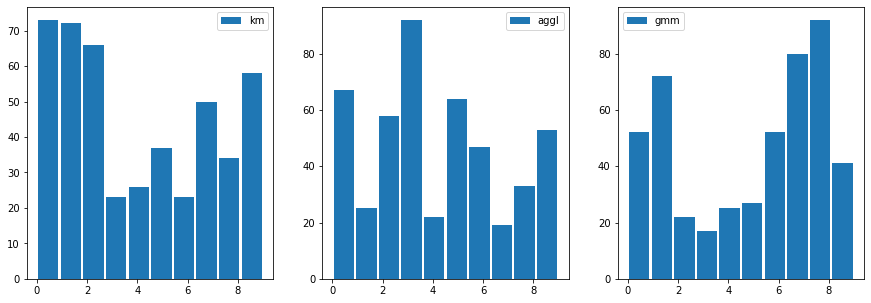

In [28]:


def plotclusterdist(df, features,clusters):
    for i in range(len(features)):
        if i % 3 == 0:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
            ax1.hist(df[df.enbloc==0][features[i]],bins=clusters,rwidth = 0.90, label=features[i])
            ax1.legend(loc = "best")
        elif i % 3 == 1:
            ax2.hist(df[features[i]], bins=clusters, rwidth = 0.90, label=features[i])
            ax2.legend(loc = "best")
        else:
            ax3.hist(df[features[i]], bins=clusters,rwidth = 0.90, label=features[i])
            ax3.legend(loc = "best")
            
plotclusterdist(results, results.columns[16:19],15)

<AxesSubplot:xlabel='gmm', ylabel='gmmprob'>

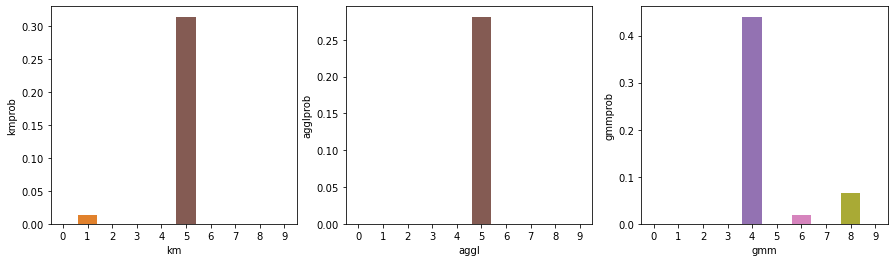

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

sns.barplot(x='km',y='kmprob',data=results, ax=ax1)
sns.barplot(x='aggl',y='agglprob',data=results, ax=ax2)
sns.barplot(x='gmm',y='gmmprob',data=results, ax=ax3)